<a href="https://colab.research.google.com/github/luisflorenz/jupyter_data/blob/main/Digit_Recognizer_using_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognizer using CNN model

Let's begin by installing and importing the required modules and classes from torch, torchvision, numpy, and matplotlib.



In [ ]:
import csv
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import random


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torchsummary
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Download and explore the data


In [ ]:
! pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od


In [ ]:
data_url = 'https://www.kaggle.com/competitions/digit-recognizer/data'

In [ ]:
od.download(data_url)

Skipping, found downloaded files in "./digit-recognizer" (use force=True to force download)


In [ ]:
data_dir = '/content/digit-recognizer'

In [ ]:
print(os.listdir(data_dir))

['sample_submission.csv', 'test.csv', 'train.csv']


In [ ]:
!ls -lh {data_dir}

total 123M
-rw-r--r-- 1 root root 236K Jan  9 13:09 sample_submission.csv
-rw-r--r-- 1 root root  49M Jan  9 13:09 test.csv
-rw-r--r-- 1 root root  74M Jan  9 13:09 train.csv


In [ ]:
train_dataset = pd.read_csv('/content/digit-recognizer/train.csv')
train_dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_dataset.shape
train_dataset.info()
train_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [ ]:
test_dataset = pd.read_csv('/content/digit-recognizer/test.csv')
test_dataset.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_dataset.shape
test_dataset.info()
test_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
sample_sub = pd.read_csv('/content/digit-recognizer/sample_submission.csv')
sample_sub.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


## Prepare the dataset for training.

Let's make a copy for manupitate de dataframe

In [ ]:
train_df = train_dataset.copy()

In [ ]:
test_df = test_dataset.copy()

In [ ]:
inputs = train_df.drop('label', axis = 1).to_numpy(dtype='float32')

In [ ]:
targets = train_df['label'].values.astype('int64')

In [ ]:
X = inputs
y = targets

In [ ]:
train_X, validation_X, train_y, validation_y = train_test_split(X, y, test_size = 0.15, random_state = 32)

In [ ]:
assert X.shape[0] == y.shape[0], 'X and y must have the same number of rows'

In [ ]:
X.shape

(42000, 784)

In [ ]:
test = test_df.to_numpy(dtype = 'float32')
test.shape

(28000, 784)

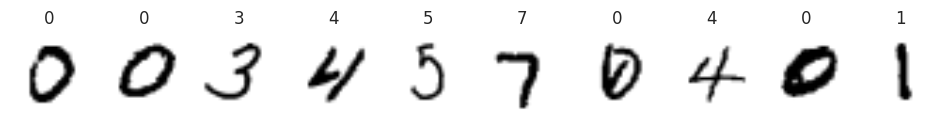

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(12, 8))

for i in range(10):
    digit = train_X[i].reshape(28, 28)
    ax[i].imshow(digit, cmap=plt.cm.binary, interpolation='bilinear')
    ax[i].set_axis_off()
    ax[i].set_title(train_y[i])

plt.show()

In [ ]:
no_class = len(set(y))
no_class

10

In [ ]:
X_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.unsqueeze(0))
])

In [ ]:
class ImageDataset(Dataset):

    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = torch.from_numpy(image).float()
        image = image.view(1, 28, 28)

        if self.labels is not None:
            label = torch.tensor(self.labels[idx])
            return image, label
        return image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_set = ImageDataset(train_X, train_y, X_transform)
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)

validation_set = ImageDataset(validation_X, validation_y, X_transform)
validation_dataloader = DataLoader(validation_set, batch_size=32, shuffle=True)

prediction_set = ImageDataset(test, None, X_transform)
prediction_dataloader = DataLoader(prediction_set, batch_size=32)

In [ ]:
train_images , train_labels = next(iter(train_dataloader))

train_images.shape

torch.Size([32, 1, 28, 28])

In [ ]:
predicted_images = next(iter(prediction_dataloader))

predicted_images.shape

torch.Size([32, 1, 28, 28])

## Define the Neural Network model for digit recognition

In [ ]:
class DigitRecognizerNN(nn.Module):
    def __init__(self):
        super(DigitRecognizerNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)


        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2, padding=1)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.6)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 5 * 5, 512)  # Input size after max pooling
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(F.silu(self.bn1(self.conv1(x))))  # Convolution, BatchNorm, silu, Pooling
        x = self.pool(F.silu(self.bn2(self.conv2(x))))
        x = self.pool(F.silu(self.bn3(self.conv3(x))))
        # print(x.shape)
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layers

        # Apply dropout
        x = self.dropout1(x)

        # Fully connected layers with silu activations
        x = F.silu(self.fc1(x))
        x = self.dropout2(x)
        x = F.silu(self.fc2(x))
        x = self.dropout3(x)
        # Output layer without activation (to be handled by loss function)
        x = F.softmax(self.fc3(x))
        return x

# Instantiate the model and move it to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Choose device based on availability
model = DigitRecognizerNN().to(device)  # Move the model to the chosen device


## Create a loss fiction and choose a omptimizer

In [ ]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

In [ ]:
# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [ ]:
def train(dataloader, model, loss_fn, optimizer, device):
    # Get the total size of the dataset
    size = len(dataloader.dataset)
    # Set the model in training mode
    model.train()
    # Initialize variables to track loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0

    # Create a progress bar using tqdm to visualize training progress
    with tqdm(total=len(dataloader), desc="Training", unit="batch") as pbar:
        # Iterate through each batch in the dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Move data to the specified device (GPU or CPU)
            X, y = X.to(device), y.to(device)

            # Zero the gradients to prepare for backpropagation
            optimizer.zero_grad()
            # Forward pass: compute predictions
            pred = model(X)
            # Calculate the loss
            loss = loss_fn(pred, y)
            # Backpropagation: compute gradients
            loss.backward()
            # Update model parameters using the optimizer
            optimizer.step()

            # Update running loss
            running_loss += loss.item()
            # Calculate predicted labels by finding the index of the maximum value along dim=1
            predicted = torch.argmax(pred, dim=1)
            # Update total number of samples processed
            total += y.size(0)
            # Update number of correctly predicted samples
            correct += (predicted == y).sum().item()

            # Update the progress bar
            pbar.update(1)
            # Update displayed metrics in the progress bar
            pbar.set_postfix({'loss': running_loss / (batch + 1), 'accuracy': 100 * correct / total})

    # Calculate epoch-level loss and accuracy
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / size
    # Print epoch-level metrics
    print(f"End of Epoch: Avg loss: {epoch_loss:.8f}, Accuracy: {epoch_acc:.8f}%\n")

def validate(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        with tqdm(total=len(dataloader), desc="Validation", unit="batch") as pbar:
            for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = loss_fn(pred, y)

                val_loss += loss.item()
                predicted = torch.argmax(pred, dim=1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

                pbar.update(1)
                pbar.set_postfix({'val_loss': val_loss / (batch + 1), 'val_accuracy': 100 * correct / total})

    epoch_loss = val_loss / len(dataloader)
    epoch_acc = 100 * correct / size
    print(f"End of Validation: Avg loss: {epoch_loss:.8f}, Accuracy: {epoch_acc:.8f}%\n")


## Let's train the model

In [ ]:
# Training loop
epochs = 30

In [ ]:
# Loop through each epoch
for epoch in range(epochs):
    # Print the current epoch number
    print(f"Epoch {epoch + 1}")

    # Execute the training process for the current epoch
    train(train_dataloader, model, loss_fn, optimizer, device)

    # Update the learning rate using the scheduler after completing an epoch
    scheduler.step()

# Validation after training
validate(validation_dataloader, model, loss_fn, device)

# Once all epochs are completed, print the end of training message
print("End of training. Saving model...")

# Save the trained model's state dictionary to a file named "model.pth"
torch.save(model.state_dict(), "model.pth")

Epoch 1


Training:   0%|          | 0/1116 [00:00<?, ?batch/s]<ipython-input-88-7744ca467261>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))
Training: 100%|██████████| 1116/1116 [00:08<00:00, 127.75batch/s, loss=1.55, accuracy=91.2]


End of Epoch: Avg loss: 1.55361107, Accuracy: 91.18207283%

Epoch 2


Training: 100%|██████████| 1116/1116 [00:08<00:00, 125.66batch/s, loss=1.54, accuracy=92.1]


End of Epoch: Avg loss: 1.54459994, Accuracy: 92.12885154%

Epoch 3


Training: 100%|██████████| 1116/1116 [00:08<00:00, 131.24batch/s, loss=1.54, accuracy=92.3]


End of Epoch: Avg loss: 1.54293971, Accuracy: 92.31372549%

Epoch 4


Training: 100%|██████████| 1116/1116 [00:08<00:00, 126.90batch/s, loss=1.55, accuracy=91.9]


End of Epoch: Avg loss: 1.54711081, Accuracy: 91.94397759%

Epoch 5


Training: 100%|██████████| 1116/1116 [00:09<00:00, 123.04batch/s, loss=1.55, accuracy=92]


End of Epoch: Avg loss: 1.54602260, Accuracy: 91.95518207%

Epoch 6


Training: 100%|██████████| 1116/1116 [00:08<00:00, 130.95batch/s, loss=1.55, accuracy=92]


End of Epoch: Avg loss: 1.54571647, Accuracy: 92.01400560%

Epoch 7


Training: 100%|██████████| 1116/1116 [00:08<00:00, 126.58batch/s, loss=1.55, accuracy=91.6]


End of Epoch: Avg loss: 1.54905183, Accuracy: 91.62745098%

Epoch 8


Training: 100%|██████████| 1116/1116 [00:08<00:00, 124.72batch/s, loss=1.55, accuracy=91.8]


End of Epoch: Avg loss: 1.54694157, Accuracy: 91.84033613%

Epoch 9


Training: 100%|██████████| 1116/1116 [00:08<00:00, 133.43batch/s, loss=1.51, accuracy=95.6]


End of Epoch: Avg loss: 1.50955073, Accuracy: 95.61064426%

Epoch 10


Training: 100%|██████████| 1116/1116 [00:09<00:00, 122.99batch/s, loss=1.5, accuracy=96.7]


End of Epoch: Avg loss: 1.50092316, Accuracy: 96.66666667%

Epoch 11


Training: 100%|██████████| 1116/1116 [00:09<00:00, 123.90batch/s, loss=1.5, accuracy=96.7]


End of Epoch: Avg loss: 1.50099264, Accuracy: 96.66666667%

Epoch 12


Training: 100%|██████████| 1116/1116 [00:08<00:00, 130.90batch/s, loss=1.5, accuracy=96.9]


End of Epoch: Avg loss: 1.49950729, Accuracy: 96.90476190%

Epoch 13


Training: 100%|██████████| 1116/1116 [00:08<00:00, 124.48batch/s, loss=1.5, accuracy=97.1]


End of Epoch: Avg loss: 1.49766042, Accuracy: 97.05882353%

Epoch 14


Training: 100%|██████████| 1116/1116 [00:09<00:00, 123.57batch/s, loss=1.5, accuracy=97.1]


End of Epoch: Avg loss: 1.49685274, Accuracy: 97.12044818%

Epoch 15


Training: 100%|██████████| 1116/1116 [00:08<00:00, 132.05batch/s, loss=1.5, accuracy=97.1]


End of Epoch: Avg loss: 1.49592848, Accuracy: 97.12044818%

Epoch 16


Training: 100%|██████████| 1116/1116 [00:08<00:00, 125.47batch/s, loss=1.5, accuracy=97.2]


End of Epoch: Avg loss: 1.49585290, Accuracy: 97.19327731%

Epoch 17


Training: 100%|██████████| 1116/1116 [00:08<00:00, 127.79batch/s, loss=1.49, accuracy=97.7]


End of Epoch: Avg loss: 1.49073805, Accuracy: 97.65546218%

Epoch 18


Training: 100%|██████████| 1116/1116 [00:08<00:00, 132.01batch/s, loss=1.49, accuracy=97.7]


End of Epoch: Avg loss: 1.49065769, Accuracy: 97.68627451%

Epoch 19


Training: 100%|██████████| 1116/1116 [00:09<00:00, 123.40batch/s, loss=1.49, accuracy=97.7]


End of Epoch: Avg loss: 1.49015997, Accuracy: 97.70588235%

Epoch 20


Training: 100%|██████████| 1116/1116 [00:08<00:00, 128.04batch/s, loss=1.49, accuracy=97.8]


End of Epoch: Avg loss: 1.48952592, Accuracy: 97.80112045%

Epoch 21


Training: 100%|██████████| 1116/1116 [00:08<00:00, 129.15batch/s, loss=1.49, accuracy=97.7]


End of Epoch: Avg loss: 1.48986577, Accuracy: 97.73949580%

Epoch 22


Training: 100%|██████████| 1116/1116 [00:09<00:00, 122.40batch/s, loss=1.49, accuracy=97.8]


End of Epoch: Avg loss: 1.48972008, Accuracy: 97.83193277%

Epoch 23


Training: 100%|██████████| 1116/1116 [00:08<00:00, 129.93batch/s, loss=1.49, accuracy=97.8]


End of Epoch: Avg loss: 1.48907589, Accuracy: 97.84593838%

Epoch 24


Training: 100%|██████████| 1116/1116 [00:08<00:00, 124.23batch/s, loss=1.49, accuracy=97.8]


End of Epoch: Avg loss: 1.48946243, Accuracy: 97.82352941%

Epoch 25


Training: 100%|██████████| 1116/1116 [00:08<00:00, 124.64batch/s, loss=1.49, accuracy=97.9]


End of Epoch: Avg loss: 1.48923098, Accuracy: 97.86834734%

Epoch 26


Training: 100%|██████████| 1116/1116 [00:08<00:00, 127.59batch/s, loss=1.49, accuracy=97.9]


End of Epoch: Avg loss: 1.48867962, Accuracy: 97.91596639%

Epoch 27


Training: 100%|██████████| 1116/1116 [00:09<00:00, 123.87batch/s, loss=1.49, accuracy=97.8]


End of Epoch: Avg loss: 1.48971919, Accuracy: 97.82072829%

Epoch 28


Training: 100%|██████████| 1116/1116 [00:09<00:00, 122.96batch/s, loss=1.49, accuracy=97.8]


End of Epoch: Avg loss: 1.48940732, Accuracy: 97.82913165%

Epoch 29


Training: 100%|██████████| 1116/1116 [00:08<00:00, 131.15batch/s, loss=1.49, accuracy=97.9]


End of Epoch: Avg loss: 1.48914615, Accuracy: 97.87114846%

Epoch 30


Training: 100%|██████████| 1116/1116 [00:09<00:00, 123.99batch/s, loss=1.49, accuracy=97.9]


End of Epoch: Avg loss: 1.48853805, Accuracy: 97.85714286%



Validation: 100%|██████████| 197/197 [00:00<00:00, 226.63batch/s, val_loss=1.48, val_accuracy=98.5]


End of Validation: Avg loss: 1.47739905, Accuracy: 98.52380952%

End of training. Saving model...


## Les's validate the model

Validation:   0%|          | 0/197 [00:00<?, ?batch/s]<ipython-input-88-7744ca467261>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))
Validation: 100%|██████████| 197/197 [00:00<00:00, 220.51batch/s, val_loss=1.48, val_accuracy=98.5]


End of Validation: Avg loss: 1.47740317, Accuracy: 98.52380952%



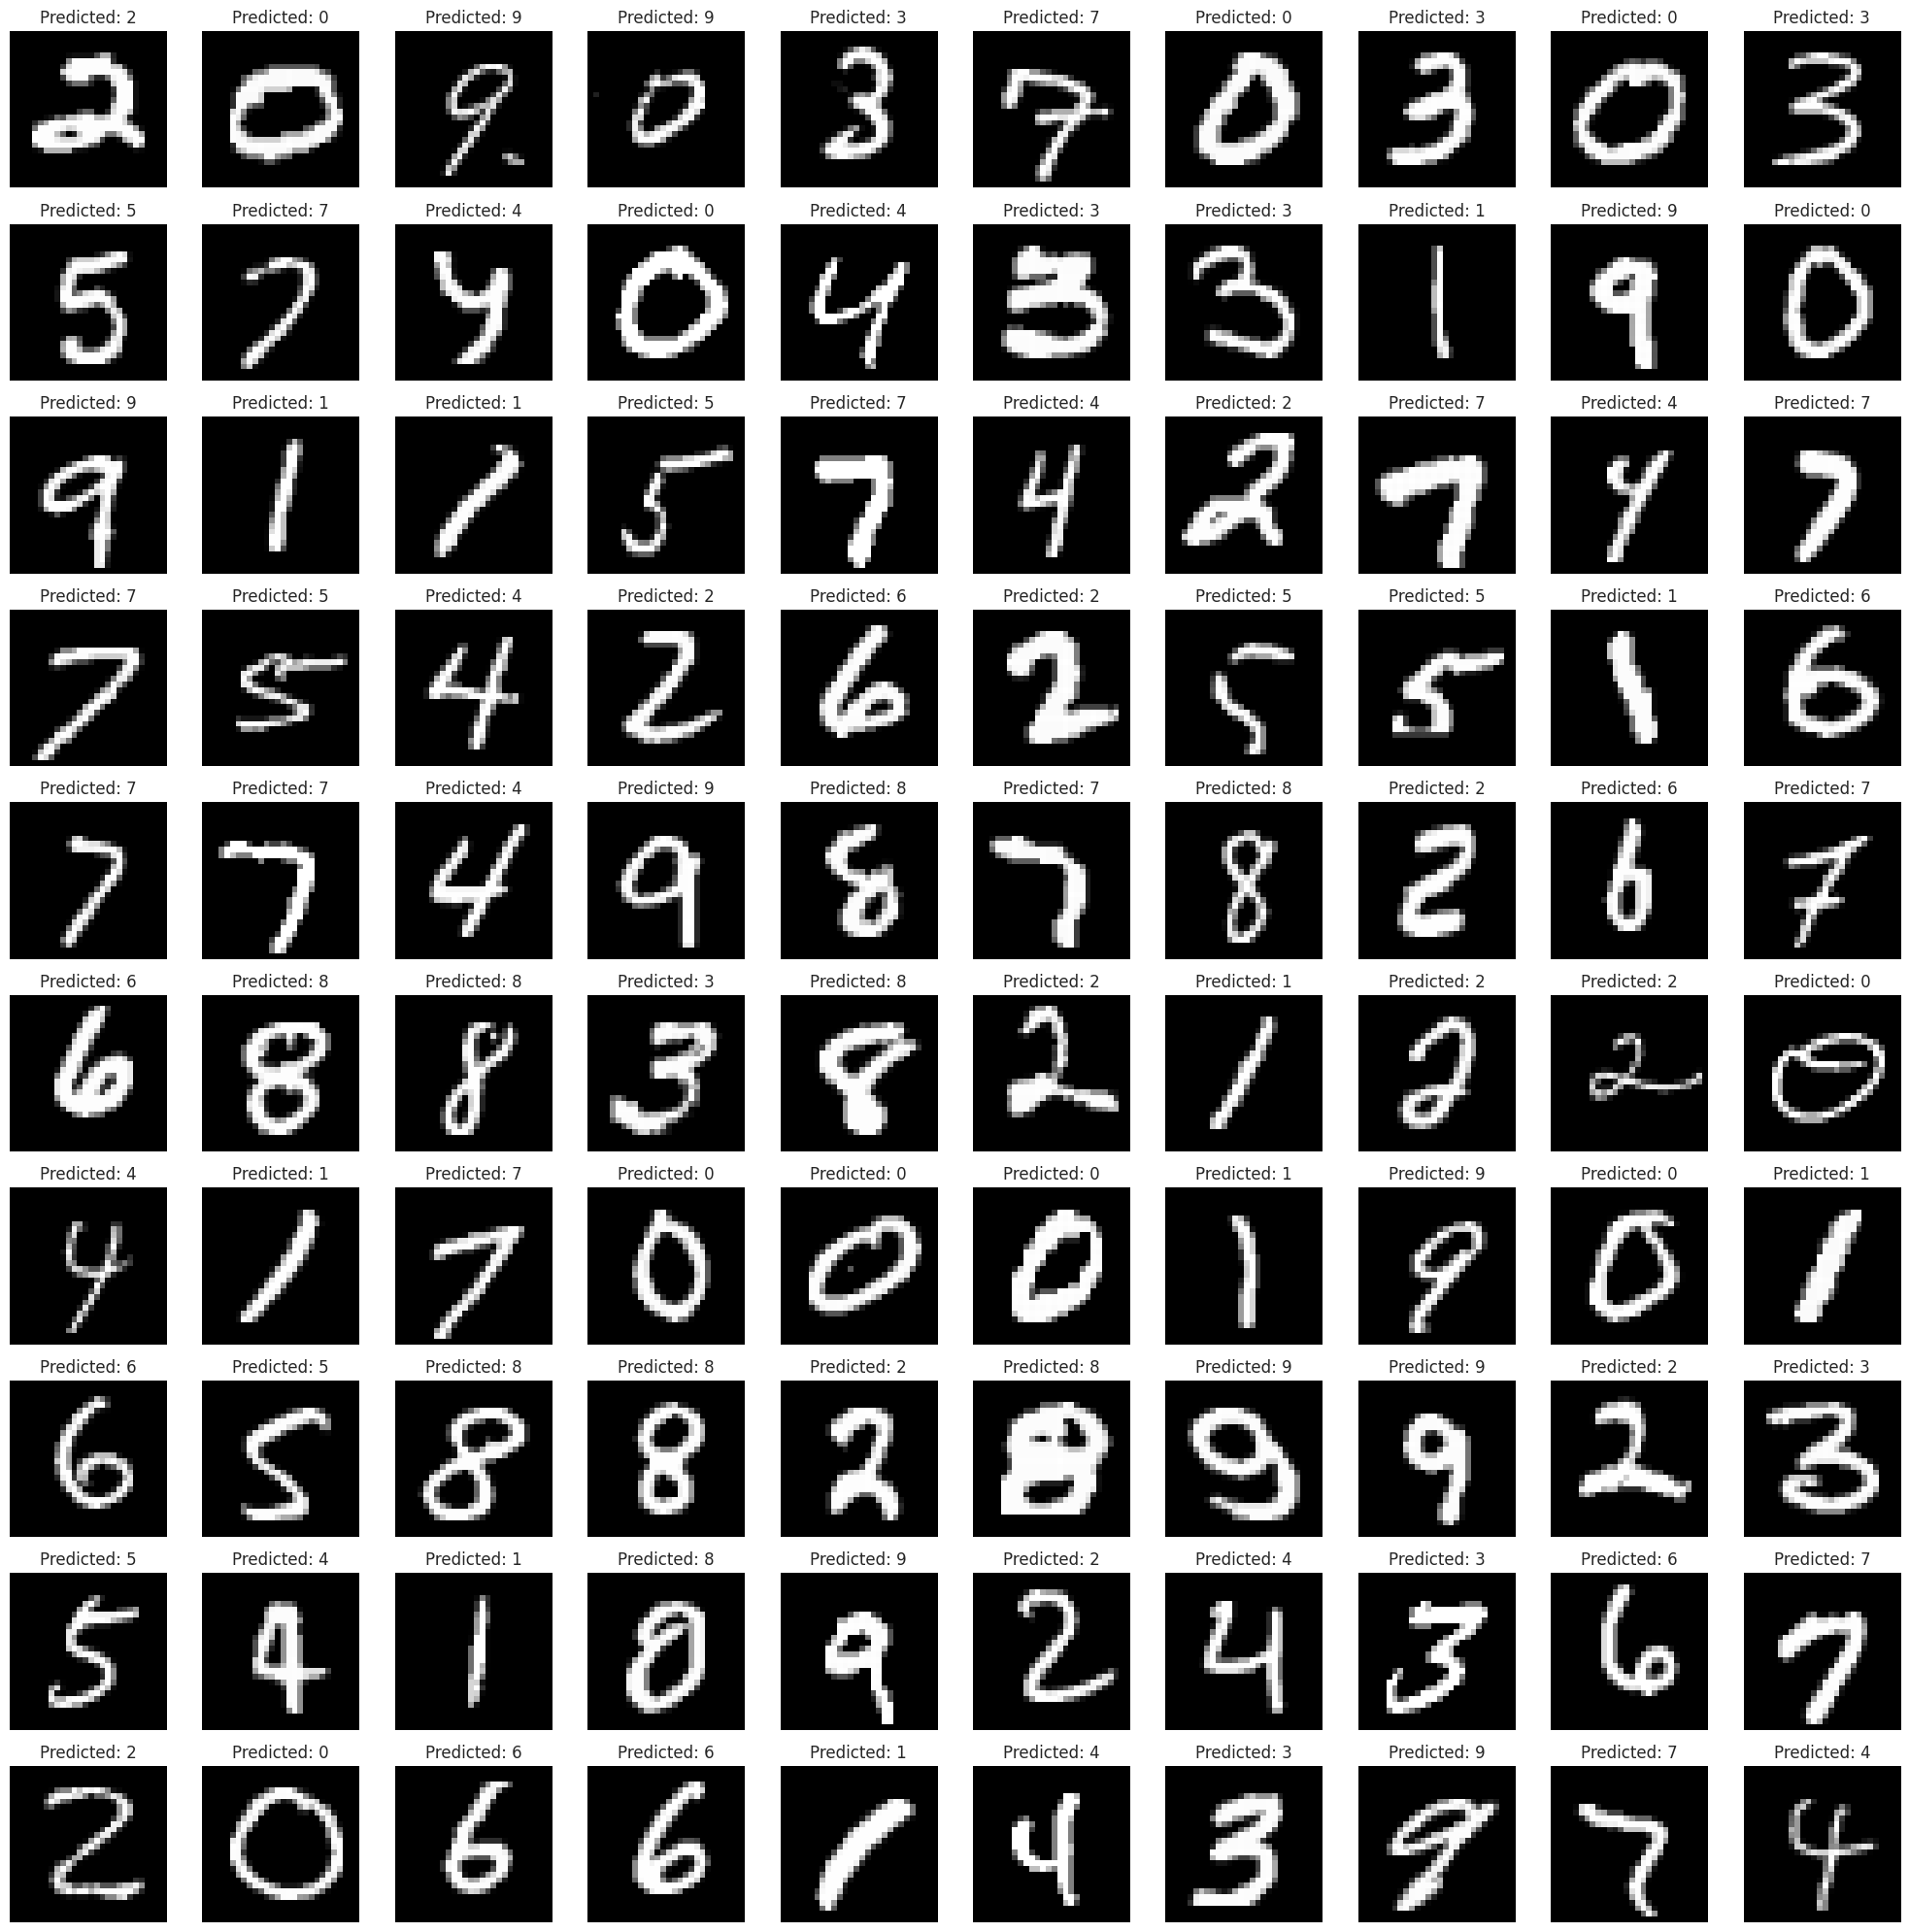

In [ ]:
validate(validation_dataloader, model, loss_fn, device)

# Set the model to evaluation mode
model.eval()

# List to store predicted labels
predictions = []
true_labels = []

# Disable gradient calculation since we're only predicting
with torch.no_grad():
    # Iterate through the test data loader
    for data in prediction_dataloader:
        # Move input data to the same device as the model
        data = data.to(device)

        # Get predictions from the model
        outputs = model(data)
        # Extract the predicted labels by finding the index of the maximum value
        _, predicted = torch.max(outputs.data, 1)
        # Extend the predictions list with the predicted labels (move to CPU if necessary)
        predictions.extend(predicted.cpu().tolist())

        # Extend true labels list (move to CPU if necessary)
        true_labels.extend(data.cpu().tolist())

# Create a DataFrame for submission with ImageId and predicted labels
submission = pd.DataFrame({
    "ImageId": range(1, len(predictions) + 1),  # ImageId starts from 1
    "Label": predictions  # Predicted labels
})

# Save the submission DataFrame to a CSV file named 'digits.csv' without including the index
submission.to_csv('digits_nn.csv', index=False)

# Get a random selection of 20 indices from the dataset
random_indices = random.sample(range(len(prediction_dataloader.dataset)), 20)

# Define the number of rows and columns for the subplot grid
num_rows = 10
num_cols = 10

# Create a figure and set its size
plt.figure(figsize=(20, 20))

# Loop through indices of images (replace this with your data)
for idx in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(prediction_dataloader.dataset[idx][0].squeeze(), cmap='gray')  # Display the image
    plt.axis('off')  # Hide axes
    plt.title(f"Predicted: {predictions[idx]}")  # Show the predicted label as title

plt.tight_layout()  # Adjust layout
plt.show()  # Show the plot